In [1]:
# import importlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from matplotlib.image import imread


%matplotlib inline

import cmocean
from glob import glob
import os

from datetime import timedelta, datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import gridspec


import pop_tools

#import oae_smyle
import util
from scipy.spatial import ConvexHull, Delaunay
import random
import importlib
import gsw

In [3]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
tlong = grid.TLONG.values
tlat = grid.TLAT.values

The following code demonstrates how to directly read a case of model output

In [12]:
def get_case(region='Pacific', season='Jan', polygon=33):
    
    '''
    To generate case name, given:
        region: Pacific, Atlantic, South
        season: Jan, Apr, Jul, Oct
        polygon: polygon index, starting from 0
    '''
    
    season_to_index = {'Jan': 0, 'Apr': 1, 'Jul': 2, 'Oct': 3}
    region_to_alk_forcing_spec = {'Pacific': 'North_Pacific_basin', 'Atlantic': 'North_Atlantic_basin', 'South': 'South', 'Southern_Ocean': 'Southern_Ocean'}

    # get foring index in this region
    if season in season_to_index:
        forcing_id = (polygon) * 4 + season_to_index[season]
    else:
        raise TypeError("Input season as: Jan, Apr, Jul, Oct")

    # all forcing files
    alk_forcing_files = glob(f'/glade/scratch/mengyangz/oae-dor-global-efficiency/data/*{region}*')
    alk_forcing_files.sort()
    for i in range(len(alk_forcing_files)):
        alk_forcing_files[i] = os.path.basename(alk_forcing_files[i][:-3])

    if region in region_to_alk_forcing_spec:
        alk_forcing_spec = region_to_alk_forcing_spec[region]
    else:
        raise TypeError("Input region as: Pacific, Atlantic, South")
    alk_forcing = alk_forcing_files[forcing_id]
    case = f"smyle-fosi.{alk_forcing_spec}.{alk_forcing}"

    return case

In [85]:
def get_oae_eff_curve(region='Pacific', season='Jan', polygon=9):
    
    '''
    To generate case name, given:
        region: Pacific, Atlantic, South
        season: Jan, Apr, Jul, Oct
        polygon: polygon index, starting from 0
    '''
    
    oae_eff_curves_global = xr.open_dataset('./all_curves_global.nc')
    # get foring index in this region
    season_to_index = {'Jan': 0, 'Apr': 1, 'Jul': 2, 'Oct': 3}
    
    return oae_eff_curves_global.isel(season=season_to_index[season]).sel(region=region, polygon=polygon)

In [13]:
def get_ds(region='Atlantic', season='Jan', polygon=1):

    '''return datasett for a case'''
    case = get_case(region=region, season=season, polygon=polygon)
    print(case)

    ds = oae_smyle.open_dataset(case, stream='pop.h')
    ds = util.process(ds)

    oae_result = get_oae_eff_curve(region=region, season=season, polygon=polygon)

    # vertical distribution of excess ALK
    alk_invertical = (ds.ALK_excess * ds.dz * ds.TAREA).sum(['nlat', 'nlon']) * 1e-9  # 1e3 meq, should be 1e-6 for meq
    alk_invertical = alk_invertical.compute()
    alk_total = alk_invertical.sum(['z_t'])  # meq
    frac_alk_invertical = alk_invertical / alk_total
    frac_alk_invertical = frac_alk_invertical.compute()
    
    return ds, oae_result, alk_invertical, frac_alk_invertical, alk_total

Read a case

High latitude North Atlantic

In [8]:
%%time
ds, oae_result, alk_invertical, frac_alk_invertical, alk_total = get_ds(region='Atlantic', season='Jan', polygon=0)
ds_apr, oae_result_apr, alk_invertical_apr, frac_alk_invertical_apr, alk_total_apr = get_ds(region='Atlantic', season='Apr', polygon=0)
ds_jul, oae_result_jul, alk_invertical_jul, frac_alk_invertical_jul, alk_total_jul = get_ds(region='Atlantic', season='Jul', polygon=0)
ds_oct, oae_result_oct, alk_invertical_oct, frac_alk_invertical_oct, alk_total_oct = get_ds(region='Atlantic', season='Oct', polygon=0)

smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.000-1999-01
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.000-1999-04
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.000-1999-07
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.000-1999-10
CPU times: user 2min 32s, sys: 2min 46s, total: 5min 18s
Wall time: 5min 6s


Gulf of St. Lawrence

In [9]:
%%time
ds_63, oae_result_63, alk_invertical_63, frac_alk_invertical_63, alk_total_63 = get_ds(region='Atlantic', season='Jan', polygon=63)
ds_apr_63, oae_result_apr_63, alk_invertical_apr_63, frac_alk_invertical_apr_63, alk_total_apr_63 = get_ds(region='Atlantic', season='Apr', polygon=63)
ds_jul_63, oae_result_jul_63, alk_invertical_jul_63, frac_alk_invertical_jul_63, alk_total_jul_63 = get_ds(region='Atlantic', season='Jul', polygon=63)
ds_oct_63, oae_result_oct_63, alk_invertical_oct_63, frac_alk_invertical_oct_63, alk_total_oct_63 = get_ds(region='Atlantic', season='Oct', polygon=63)

smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-1999-01
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-1999-04
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-1999-07
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-1999-10
CPU times: user 2min 32s, sys: 2min 53s, total: 5min 25s
Wall time: 5min 9s


Subtropical North Atlantic

In [31]:
%%time
ds_142, oae_result_142, alk_invertical_142, frac_alk_invertical_142, alk_total_142 = get_ds(region='Atlantic', season='Jan', polygon=142)
ds_apr_142, oae_result_apr_142, alk_invertical_apr_142, frac_alk_invertical_apr_142, alk_total_apr_142 = get_ds(region='Atlantic', season='Apr', polygon=142)
ds_jul_142, oae_result_jul_142, alk_invertical_jul_142, frac_alk_invertical_jul_142, alk_total_jul_142 = get_ds(region='Atlantic', season='Jul', polygon=142)
ds_oct_142, oae_result_oct_142, alk_invertical_oct_142, frac_alk_invertical_oct_142, alk_total_oct_142 = get_ds(region='Atlantic', season='Oct', polygon=142)

smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.142-1999-01
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.142-1999-04
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.142-1999-07
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.142-1999-10
CPU times: user 2min 20s, sys: 58.4 s, total: 3min 18s
Wall time: 5min 19s


Equatorial Atlantic

In [11]:
%%time
ds_129, oae_result_129, alk_invertical_129, frac_alk_invertical_129, alk_total_129 = get_ds(region='Atlantic', season='Jan', polygon=129)
ds_apr_129, oae_result_apr_129, alk_invertical_apr_129, frac_alk_invertical_apr_129, alk_total_apr_129 = get_ds(region='Atlantic', season='Apr', polygon=129)
ds_jul_129, oae_result_jul_129, alk_invertical_jul_129, frac_alk_invertical_jul_129, alk_total_jul_129 = get_ds(region='Atlantic', season='Jul', polygon=129)
ds_oct_129, oae_result_oct_129, alk_invertical_oct_129, frac_alk_invertical_oct_129, alk_total_oct_129 = get_ds(region='Atlantic', season='Oct', polygon=129)

smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.129-1999-01
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.129-1999-04
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.129-1999-07
smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.129-1999-10
CPU times: user 2min 32s, sys: 2min 54s, total: 5min 26s
Wall time: 5min 1s


# Read curves directly

In [96]:
ds = xr.open_dataset('./Plumes_data/pCO2_SURF_excess_0_Atlantic.nc')
ds_63 = xr.open_dataset('./Plumes_data/pCO2_SURF_excess_63_Atlantic.nc')
ds_142 = xr.open_dataset('./Plumes_data/pCO2_SURF_excess_142_Atlantic.nc')
d_129 = xr.open_dataset('./Plumes_data/pCO2_SURF_excess_129_Atlantic.nc')

In [4]:
frac_alk_invertical = xr.open_dataset('./Plumes_data/frac_alk_invertical_0_Atlantic.nc')
frac_alk_invertical_apr = xr.open_dataset('./Plumes_data/frac_alk_invertical_apr_0_Atlantic.nc')
frac_alk_invertical_jul = xr.open_dataset('./Plumes_data/frac_alk_invertical_jul_0_Atlantic.nc')
frac_alk_invertical_oct = xr.open_dataset('./Plumes_data/frac_alk_invertical_oct_0_Atlantic.nc')

frac_alk_invertical_63 = xr.open_dataset('./Plumes_data/frac_alk_invertical_63_Atlantic.nc')
frac_alk_invertical_apr_63 = xr.open_dataset('./Plumes_data/frac_alk_invertical_apr_63_Atlantic.nc')
frac_alk_invertical_jul_63 = xr.open_dataset('./Plumes_data/frac_alk_invertical_jul_63_Atlantic.nc')
frac_alk_invertical_oct_63 = xr.open_dataset('./Plumes_data/frac_alk_invertical_oct_63_Atlantic.nc')

frac_alk_invertical_142 = xr.open_dataset('./Plumes_data/frac_alk_invertical_142_Atlantic.nc')
frac_alk_invertical_apr_142 = xr.open_dataset('./Plumes_data/frac_alk_invertical_apr_142_Atlantic.nc')
frac_alk_invertical_jul_142 = xr.open_dataset('./Plumes_data/frac_alk_invertical_jul_142_Atlantic.nc')
frac_alk_invertical_oct_142 = xr.open_dataset('./Plumes_data/frac_alk_invertical_oct_142_Atlantic.nc')

frac_alk_invertical_129 = xr.open_dataset('./Plumes_data/frac_alk_invertical_129_Atlantic.nc')
frac_alk_invertical_apr_129 = xr.open_dataset('./Plumes_data/frac_alk_invertical_apr_129_Atlantic.nc')
frac_alk_invertical_jul_129 = xr.open_dataset('./Plumes_data/frac_alk_invertical_jul_129_Atlantic.nc')
frac_alk_invertical_oct_129 = xr.open_dataset('./Plumes_data/frac_alk_invertical_oct_129_Atlantic.nc')

In [86]:
oae_result = get_oae_eff_curve(region='Atlantic', season='Jan', polygon=0)
oae_result_apr = get_oae_eff_curve(region='Atlantic', season='Apr', polygon=0)
oae_result_jul = get_oae_eff_curve(region='Atlantic', season='Jul', polygon=0)
oae_result_oct = get_oae_eff_curve(region='Atlantic', season='Oct', polygon=0)

oae_result_63 = get_oae_eff_curve(region='Atlantic', season='Jan', polygon=63)
oae_result_apr_63 = get_oae_eff_curve(region='Atlantic', season='Apr', polygon=63)
oae_result_jul_63 = get_oae_eff_curve(region='Atlantic', season='Jul', polygon=63)
oae_result_oct_63 = get_oae_eff_curve(region='Atlantic', season='Oct', polygon=63)

oae_result_142 = get_oae_eff_curve(region='Atlantic', season='Jan', polygon=142)
oae_result_apr_142 = get_oae_eff_curve(region='Atlantic', season='Apr', polygon=142)
oae_result_jul_142 = get_oae_eff_curve(region='Atlantic', season='Jul', polygon=142)
oae_result_oct_142 = get_oae_eff_curve(region='Atlantic', season='Oct', polygon=142)

oae_result_129 = get_oae_eff_curve(region='Atlantic', season='Jan', polygon=129)
oae_result_apr_129 = get_oae_eff_curve(region='Atlantic', season='Apr', polygon=129)
oae_result_jul_129 = get_oae_eff_curve(region='Atlantic', season='Jul', polygon=129)
oae_result_oct_129 = get_oae_eff_curve(region='Atlantic', season='Oct', polygon=129)

In [97]:
dss = [ds, ds_63, ds_142, ds_129]

oae_effs = [ [oae_result, oae_result_apr, oae_result_jul, oae_result_oct],\
[oae_result_63, oae_result_apr_63, oae_result_jul_63, oae_result_oct_63],\
[oae_result_142, oae_result_apr_142, oae_result_jul_142, oae_result_oct_142],\
[oae_result_129, oae_result_apr_129, oae_result_jul_129, oae_result_oct_129] ]

fra_alks = [ [frac_alk_invertical, frac_alk_invertical_apr, frac_alk_invertical_jul, frac_alk_invertical_oct],\
[frac_alk_invertical_63, frac_alk_invertical_apr_63, frac_alk_invertical_jul_63, frac_alk_invertical_oct_63],\
[frac_alk_invertical_142, frac_alk_invertical_apr_142, frac_alk_invertical_jul_142, frac_alk_invertical_oct_142],\
[frac_alk_invertical_129, frac_alk_invertical_apr_129, frac_alk_invertical_jul_129, frac_alk_invertical_oct_129] ]

In [20]:
# atlantic polygon masks
final_polygon_mask_atlantic = np.load('./polygon_data/Atlantic_final_polygon_mask.npy')
final_polygon_vertices_atlantic = np.load('./polygon_data/Atlantic_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_atlantic = np.load('./polygon_data/Atlantic_final_cluster_centers.npy', allow_pickle=True)

In [21]:
def plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, ii):
    # a list of colors
    # colorsss = list(mcolors.TABLEAU_COLORS.values())
    # ind_color = np.arange(len(colorsss)) # 0- 9

    vertices = np.array(final_polygon_vertices_atlantic[ii])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[iii] for iii in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())

    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[ii] == 1)
    ax.scatter(tlong[index], tlat[index], c='k', s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[ii, 0]-2, cluster_centers_atlantic[ii, 1]-1,str(ii), fontsize=9, color='k', transform=ccrs.PlateCarree())

def no_nans(array):
    return array[~np.isnan(array)]

### Adding weighted mixed layer depth

In [26]:
poly_ind = [0, 63, 142, 129]
season = [0,1,2,3]
forcing_ind = np.zeros((4, 4))

for i in range(4):
    for j in range(4):
        forcing_ind[i,j] = poly_ind[i]*4 + season[j]

eff_mld = np.zeros((4, 4, 3))  # number of polygons, number of season, number of years

for i in range(4):
    for j in range(4):
        res_file = xr.open_dataset(f'./Atlantic_weighted_FG_CO2_abs/Atlantic{int(forcing_ind[i,j]):04d}.nc')
        eff_mld[i,j,0] = res_file.mld_weight_1.values[12*1]/100 # year 1, no need for offset by season, because it was all 180 mths
        eff_mld[i,j,1] = res_file.mld_weight_1.values[12*2]/100
        eff_mld[i,j,2] = res_file.mld_weight_1.values[12*8]/100

# Fig. 5
Decomposition of gas exchange timescale

In [27]:
all_curves_global = xr.open_dataset('./all_curves_global.nc', decode_times=False)
all_curves_global_tau_FG_CO2 = xr.open_dataset('./all_curves_global_tau_FG_CO2.nc', decode_times=False)

CPU times: user 496 ms, sys: 6.19 ms, total: 502 ms
Wall time: 525 ms


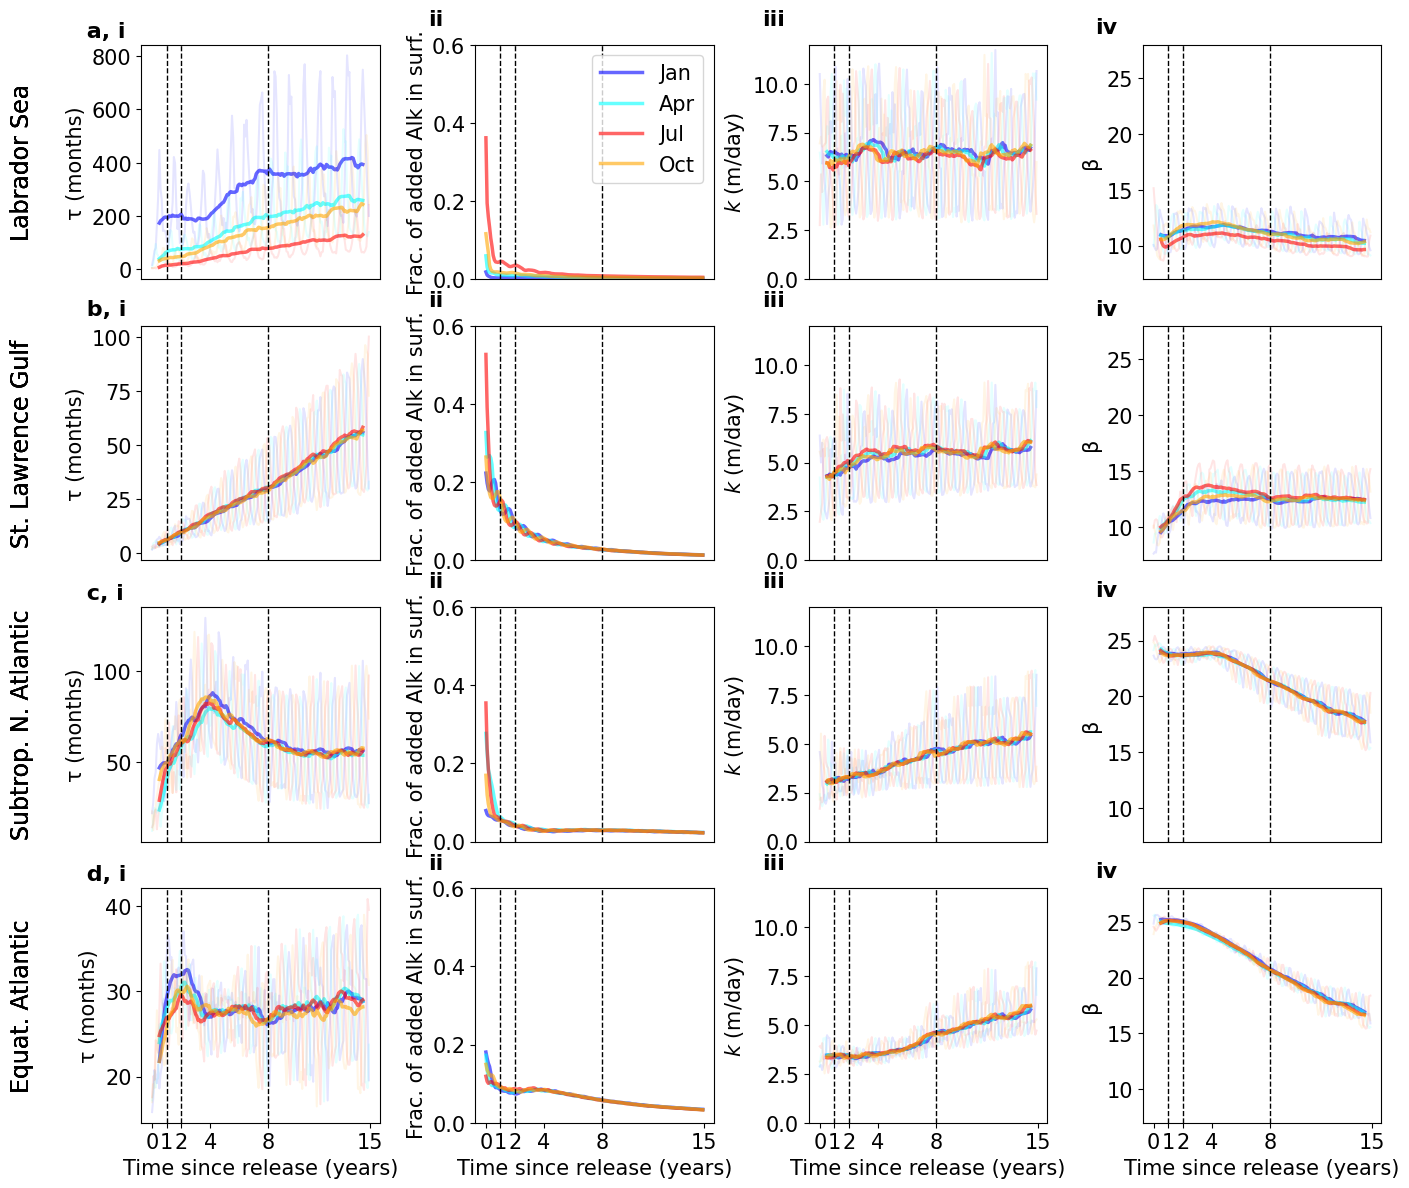

In [28]:
%%time
plt.rcParams.update({'font.size': 15})

nrow = 4
ncol = 4

fig = plt.figure(figsize=(16,14))
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1, 1])

colors = ['blue', 'cyan', 'red', 'orange']
labels = ['Jan', 'Apr', 'Jul', 'Oct']
lon_mins = [-80, -80, -80, -80]
lon_maxs = [25, 25, 30, 30]
lat_mins = [0, 0, 0, -40]
lat_maxs = [80, 80, 80, 40]
central_longitudes = [0, 0, 0, 0]

reg = 'Atlantic'
polys = [0, 63, 142, 129]


#text_position = [750,95,125,39.5]
text_position = [870,110,140,43]
text_position_1 = [870,110,140,43]
ll = ['a', 'b', 'c', 'd']
region_names = ['Labrador Sea', 'St. Lawrence Gulf', 'Subtrop. N. Atlantic', 'Equat. Atlantic']

for i in range(nrow):
    
    surf_dil = all_curves_global.sel(region=reg, polygon=polys[i])  # surface dilution curves for a polygon, with 4 seasons
    tau_comp = all_curves_global_tau_FG_CO2.sel(region=reg, polygon=polys[i]) # tau gax componets for a region
    
    for j in range(ncol): 

        ################ tau_gas_effective_MLD
        if j == 0:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-5, text_position[i], f' {ll[i]}, i', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(tau_comp.isel(season=k).tau_gas_approxi_weight_1_effectiveMLD.values/30), linewidth=1.5, color=colors[k], alpha=0.1)
                ind_not_nan = ~np.isnan(tau_comp.isel(season=k).tau_gas_approxi_weight_1_effectiveMLD.values)
                ax.plot(tarray, tau_comp.isel(season=k).tau_gas_approxi_weight_1_effectiveMLD.rolling(time=12, min_periods=12, center=True).mean().values[ind_not_nan]/30, linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)

                #ax.set_ylim(7, 26)
                ax.set_ylabel('τ (months)')
                ax.text(-0.5, 0.5, f'{region_names[i]}', ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize=17)  
                #ax.text(-8, text_position[i]/3, f'{region_names[i]}', rotation=90)
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
        
        ################ surf_dil
        elif j == 1:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-4, 0.65, 'ii', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(surf_dil.isel(season=k).frac_ALK_excess_surf.values), linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)
                ax.set_ylim(0, 0.6)
                ax.set_ylabel('Frac. of added Alk in surf.')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])
            if i == 0:
                ax.legend(loc='upper right')

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )


        ################ piston velocity
        elif j == 2:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-4, 13, 'iii', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(tau_comp.isel(season=k).piston_weight_1.values/100*86400), linewidth=1.5, color=colors[k], label=labels[k], alpha=0.1)
                ind_not_nan = ~np.isnan(tau_comp.isel(season=k).piston_weight_1.values)
                ax.plot(tarray, tau_comp.isel(season=k).piston_weight_1.rolling(time=12, min_periods=12, center=True).mean().values[ind_not_nan]/100*86400, linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)

                ax.set_ylim(0, 12)
                ax.set_ylabel('$k$ (m/day)')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
                
        ################ dDIC_dCO2
        elif j == 3:
            ax = fig.add_subplot(nrow, ncol, i*ncol+j+1)
            ax.text(-4, 29, 'iv', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(tau_comp.isel(season=k).dDICdCO2_approxi_weight_1.values), linewidth=1.5, color=colors[k], label=labels[k], alpha=0.1)
                ind_not_nan = ~np.isnan(tau_comp.isel(season=k).dDICdCO2_approxi_weight_1.values)
                ax.plot(tarray, tau_comp.isel(season=k).dDICdCO2_approxi_weight_1.rolling(time=12, min_periods=12, center=True).mean().values[ind_not_nan], linewidth=2.5, color=colors[k], label=labels[k], alpha=0.6)

                ax.set_ylim(7, 28)
                ax.set_ylabel('β')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
                
plt.subplots_adjust(wspace=0.4, hspace=0.2)

#plt.savefig('./Figurex_tau_gas_components_4x4.png', dpi=400, bbox_inches='tight')

# Adding histograms of CO2 uptake

### Distances of each grid point to a polygon center, assign each grid point to a ring

In [29]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
tlong = grid.TLONG.values
tlat = grid.TLAT.values

In [30]:
tlong_conv = np.where(tlong > 180, tlong - 360, tlong)

In [32]:
# atlantic
final_polygon_mask_atlantic = np.load('./polygon_data/Atlantic_final_polygon_mask.npy')
final_polygon_vertices_atlantic = np.load('./polygon_data/Atlantic_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_atlantic = np.load('./polygon_data/Atlantic_final_cluster_centers.npy', allow_pickle=True)

In [33]:
def cal_dist(target):    
    '''
    target: [lon, lat]
    '''

    n, m = tlong_conv.shape

    dist = np.zeros_like(tlong_conv)
    for i in range(n):
        for j in range(m):
            dist[i,j] = gsw.distance([tlong_conv[i,j], target[0]], [tlat[i,j], target[1]])
    return dist

In [34]:
%%time
dist_0 = cal_dist(cluster_centers_atlantic[0])
dist_63 = cal_dist(cluster_centers_atlantic[63])
dist_142 = cal_dist(cluster_centers_atlantic[142])
dist_129 = cal_dist(cluster_centers_atlantic[129])

dist_5 = cal_dist(cluster_centers_atlantic[5])

CPU times: user 30.8 s, sys: 3.68 ms, total: 30.8 s
Wall time: 33 s


In [35]:
def make_rings(dist_0, num_rings=100):

    '''
    Return ring matrix, assign each grid point to a certain ring.
    bin_edges: distances
    '''
    
    # Determine the range of distances
    min_distance = np.min(dist_0)
    max_distance = np.max(dist_0)

    # Define the bin edges to create rings
    #bin_edges = np.concatenate((np.arange(0, 2000*1e3, 50*1e3), np.arange(2000*1e3, max_distance, 100*1e3)))
    bin_edges = np.arange(0, 4100*1e3, 50*1e3)

    # Use digitize to assign each point to a ring
    rings = np.digitize(dist_0, bin_edges, right=True)
    
    return bin_edges, rings

In [36]:
bin_edges_0, rings_0 = make_rings(dist_0)
bin_edges_63, rings_63 = make_rings(dist_63)
bin_edges_142, rings_142 = make_rings(dist_142)
bin_edges_129, rings_129 = make_rings(dist_129)

bin_edges_5, rings_5 = make_rings(dist_5)

(-25.0, 0.0)

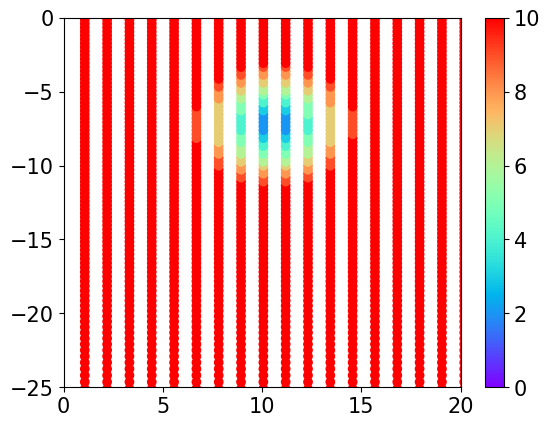

In [37]:
plt.scatter(tlong, tlat, c=rings_5, cmap='rainbow', vmin=0, vmax=10)
plt.colorbar()
plt.xlim(0,20)
plt.ylim(-25,0)

In [38]:
np.unique(rings_5)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

In [38]:
d1 = xr.open_dataset('/glade/work/mengyangz/GVP/oae-dor-global-efficiency/notebooks/Plumes_FG_CO2_histograms/Southern_Ocean-0032.nc')

FG_CO2

In [48]:
fpath = './FG_CO2_excess/'
FG_CO2_excess = xr.open_dataset(fpath + 'North_Atlantic_basin-0003.nc')

FG_CO2: mmol/m3 cm/s

TAREA: cm2

time_delta: days

In [40]:
FG_CO2_excess_area_time = (FG_CO2_excess.FG_CO2_excess * FG_CO2_excess.TAREA * FG_CO2_excess.time_delta) / 1e6 * 86400 # mmol

In [41]:
# total CO2 uptake in each ring, and each time

num_time = len(FG_CO2_excess_area_time.time) # 180 time steps
num_rings = len(bin_edges_0)

FG_CO2_rings = np.zeros((num_time, num_rings))
rings_ind = np.unique(rings_0)  # unique ring indices

for i in range(num_rings):
    ring_mask = np.where(rings_0 == rings_ind[i], 1, 0)  # 1 if in this ring
    FG_CO2_rings[:, i] = (FG_CO2_excess_area_time * ring_mask).sum(dim=['nlat', 'nlon']) # mmol
     
total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['time', 'nlat', 'nlon']).values # total CO2 uptake in 15 years, mmol
FG_CO2_rings_per = FG_CO2_rings / total_FG_CO2

In [42]:
all_rs = [3,6,12,24,72,180]
r=0
stacks = []
labels = []

for rs in all_rs:
    # sum individual histograms across the time axis into groups.
    stacks.append(np.sum(FG_CO2_rings_per[r:rs],axis=0))
    percentage = np.sum(FG_CO2_rings_per[r:rs])
    labels.append("%.1f %% in months %d-%d"%(percentage*100,r,rs))
    # move to the next block
    r=rs

In [43]:
labels

['49.8 % in months 0-3',
 '16.3 % in months 3-6',
 '6.0 % in months 6-12',
 '10.9 % in months 12-24',
 '10.8 % in months 24-72',
 '6.2 % in months 72-180']

(0.0, 4000.0)

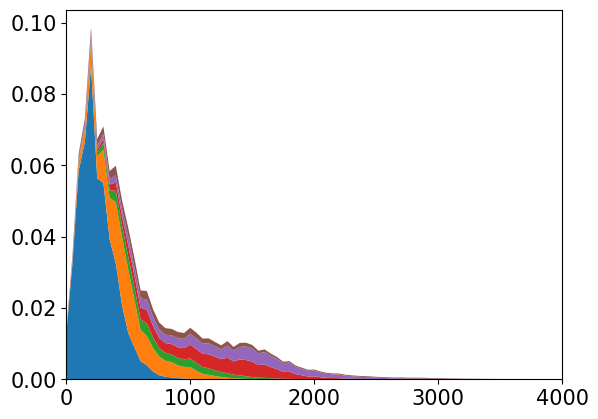

In [44]:
plt.stackplot(bin_edges_0/1000, stacks);
plt.xlim(0, 4000)

#plt.plot(bin_edges_0/1000, np.sum(FG_CO2_rings_per, axis=0), color='k', linewidth=3)

In [40]:
forcing_ind

array([[  0.,   1.,   2.,   3.],
       [252., 253., 254., 255.],
       [568., 569., 570., 571.],
       [516., 517., 518., 519.]])

Put together in functions

In [41]:
def get_cum_FG_CO2_ring(FG_CO2_excess, bin_edges_0, rings_0):
    
    '''
    Return array of cummulative percentage CO2 uptake in each rings
    '''
    
    # total CO2 uptake in each ring, and each time
    
    FG_CO2_excess_area_time = (FG_CO2_excess.FG_CO2_excess * FG_CO2_excess.TAREA * FG_CO2_excess.time_delta) / 1e6 * 86400 # mmol
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['time', 'nlat', 'nlon']).values

    num_time = len(FG_CO2_excess_area_time.time) # 180 time steps
    num_rings = len(bin_edges_0)

    FG_CO2_rings = np.zeros((num_time, num_rings))
    rings_ind = np.unique(rings_0)  # unique ring indices

    for i in range(num_rings):
        ring_mask = np.where(rings_0 == rings_ind[i], 1, 0)  # 1 if in this ring
        FG_CO2_rings[:, i] = (FG_CO2_excess_area_time * ring_mask).sum(dim=['nlat', 'nlon']) # mmol

    #total_FG_CO2 = np.sum(FG_CO2_rings) # total CO2 uptake in 15 years, mmol
    FG_CO2_rings_per = FG_CO2_rings / total_FG_CO2
    
    return FG_CO2_rings_per

def get_cum_FG_CO2_ring_4seasons(polygons, bin_edges_0, rings_0):
    
    '''
    Return array of cummulative percentage CO2 uptake in each rings, 4 seasons
    '''
    
    FG_CO2_rings_per_4seasons = np.zeros((4, 180, len(bin_edges_0)))
    
    fpath = './FG_CO2_excess/'

    ind = np.arange(polygons*4, polygons*4 + 4, 1)
    for i in range(4):
        FG_CO2_excess = xr.open_dataset(fpath + f'North_Atlantic_basin-{ind[i]:04d}.nc')
        FG_CO2_rings_per_4seasons[i, :, :] = get_cum_FG_CO2_ring(FG_CO2_excess, bin_edges_0, rings_0)
    
    return FG_CO2_rings_per_4seasons

def get_stack(FG_CO2_rings_per, long=False):

    all_rs = [3,6,12,24,72,180]
    r=0
    stacks = []
    labels = []

    for rs in all_rs:
        # sum individual histograms across the time axis into groups.
        stacks.append(np.sum(FG_CO2_rings_per[r:rs],axis=0)*100)
        percentage = np.sum(FG_CO2_rings_per[r:rs])
        
        if long==True:
            labels.append("%.1f %% in months %d-%d"%(percentage*100,r,rs))
        else:
            labels.append("%.1f %%"%(percentage*100))
        # move to the next block
        r=rs
        
    return stacks, labels

def find_element_index(arr, element_to_find):
    """
    Find the index (or indices) of a specified element in a NumPy array.

    Returns:
    - If the element is found:
      - If the element appears multiple times, returns a NumPy array of indices.
      - If the element appears only once, returns a single index.
    - If the element is not found, returns None.
    """
    indices = np.where(arr == element_to_find)[0]

    if len(indices) == 0:
        return None
    elif len(indices) == 1:
        return indices[0]
    else:
        return indices

### Get all 4 seasons for all 4 polygons

In [43]:
%%time
FG_CO2_rings_0 = get_cum_FG_CO2_ring_4seasons(0, bin_edges_0, rings_0)
FG_CO2_rings_63 = get_cum_FG_CO2_ring_4seasons(63, bin_edges_63, rings_63)
FG_CO2_rings_142 = get_cum_FG_CO2_ring_4seasons(142, bin_edges_142, rings_142)
FG_CO2_rings_129 = get_cum_FG_CO2_ring_4seasons(129, bin_edges_129, rings_129)

CPU times: user 1min 59s, sys: 1min 24s, total: 3min 24s
Wall time: 3min 38s


In [49]:
def get_ds(FG_CO2_rings_0, p):
    
    ds = xr.Dataset(
        {
            'FG_CO2_percent': (['season', 'time', 'dist2center'], FG_CO2_rings_0),
        },
        coords={'season': ['Januaray', 'April', 'July', 'October'],
                'time': FG_CO2_excess.time.values,
                'dist2center': bin_edges_0
               },
    )

    ds = ds.expand_dims(polygon=[p])
    
    return ds

In [99]:
# arrs = [FG_CO2_rings_0, FG_CO2_rings_63, FG_CO2_rings_142, FG_CO2_rings_129]
# pols = [0, 63, 142, 129]

ds_0_ = get_ds(FG_CO2_rings_0, 0)
ds_63_ = get_ds(FG_CO2_rings_63, 63)
ds_142_ = get_ds(FG_CO2_rings_142, 142)
ds_129_ = get_ds(FG_CO2_rings_129, 129)

ds_4poly = xr.concat([ds_0_, ds_63_, ds_142_, ds_129_], dim='polygon')

In [51]:
ds_4poly.to_netcdf('./Plumes_FG_CO2_percent.nc', mode='w')

# Read from here for any histogram plot

In [52]:
ds_4poly = xr.open_dataset('./Plumes_FG_CO2_percent.nc')

In [53]:
ds_4poly

<xarray.Dataset>
Dimensions:         (polygon: 4, season: 4, time: 180, dist2center: 82)
Coordinates:
  * polygon         (polygon) int64 0 63 142 129
  * season          (season) object 'Januaray' 'April' 'July' 'October'
  * time            (time) object 0347-10-16 12:00:00 ... 0362-09-16 00:00:00
  * dist2center     (dist2center) float64 0.0 5e+04 1e+05 ... 4e+06 4.05e+06
Data variables:
    FG_CO2_percent  (polygon, season, time, dist2center) float64 ...

## Map view of cumulative CO2 uptake

In [54]:
def get_cumul_CO2uptake_map(polygon):
    
    fpath = './FG_CO2_excess/'

    ind = polygon*4
    FG_CO2_excess = xr.open_dataset(fpath + f'North_Atlantic_basin-{ind:04d}.nc')
    
    FG_CO2_excess_area_time = (FG_CO2_excess.FG_CO2_excess * FG_CO2_excess.TAREA * FG_CO2_excess.time_delta) / 1e6 * 86400 # mmol
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['time', 'nlat', 'nlon']).values # total CO2 uptake in 15 years, mmol

    frac_FG_CO2 = FG_CO2_excess_area_time / total_FG_CO2*100
    frac_FG_CO2_cumul = frac_FG_CO2.sum(['time'])
    
    frac_FG_CO2_cumul = frac_FG_CO2_cumul.to_dataset(name='frac_FG_CO2_cumul')
    
    return frac_FG_CO2_cumul

In [55]:
%%time
frac_FG_CO2_map_0 = get_cumul_CO2uptake_map(0)
frac_FG_CO2_map_63 = get_cumul_CO2uptake_map(63)
frac_FG_CO2_map_142 = get_cumul_CO2uptake_map(142)
frac_FG_CO2_map_129 = get_cumul_CO2uptake_map(129)

ds_frac_FG_CO2_map = [frac_FG_CO2_map_0, frac_FG_CO2_map_63, frac_FG_CO2_map_142, frac_FG_CO2_map_129]

CPU times: user 1.06 s, sys: 1.11 s, total: 2.17 s
Wall time: 2.24 s


In [56]:
frac_FG_CO2_map_0.frac_FG_CO2_cumul.max(), frac_FG_CO2_map_0.frac_FG_CO2_cumul.min()

(<xarray.DataArray 'frac_FG_CO2_cumul' ()>
 array(0.78318086)
 Coordinates:
     z_t      float32 500.0,
 <xarray.DataArray 'frac_FG_CO2_cumul' ()>
 array(-2.90333997e-06)
 Coordinates:
     z_t      float32 500.0)

In [57]:
frac_FG_CO2_map_129.frac_FG_CO2_cumul.max().values.item()

0.19363534048795802

In [58]:
max_per = frac_FG_CO2_map_0.frac_FG_CO2_cumul.max().values.item()
ranges = np.arange(0, 2, 0.01)
#ranges = np.array([1e-3, 1e-2, 1e-1, 0.5, 1e0, 2])

Given ranges, calculate sums inside

In [59]:
def get_sum_inside(frac_FG_CO2_map_63, ranges):
    '''
    Given a list of max_values, return the sums inside
    '''
    data_array = frac_FG_CO2_map_63.frac_FG_CO2_cumul

    l_sum_inside = []
    for max_value in ranges:
        selected_data = data_array.where( (data_array >= max_value), drop=True)
        sum_inside = selected_data.sum(dim=['nlat', 'nlon']).values.item()
        l_sum_inside.append(sum_inside)
    return np.array(l_sum_inside)

In [60]:
ranges = [1e-3, 0.008, 0.02, 0.1]
print(get_sum_inside(frac_FG_CO2_map_0, ranges))
print(get_sum_inside(frac_FG_CO2_map_63, ranges))
print(get_sum_inside(frac_FG_CO2_map_142, ranges))
print(get_sum_inside(frac_FG_CO2_map_129, ranges))

[98.73780535 93.87056458 86.51149795 51.47351978]
[95.68005564 92.07829239 91.02709308 88.46934623]
[97.26243717 78.10906005 60.40436093 36.32714977]
[96.42871289 73.92344397 58.66827128 24.85023715]


In [61]:
arr = get_sum_inside(frac_FG_CO2_map_0, ranges)
int_array = list(map(int, arr))

In [62]:
int_array

[98, 93, 86, 51]

Given the sums, what should be the ranges

In [63]:
def get_max_values(frac_FG_CO2_map_63, target_sums, thresholds):
    '''
    Given an array of target_sum, return the max values that will sum to the targets.
    '''

    l_max_value = []

    data_array = frac_FG_CO2_map_63.frac_FG_CO2_cumul
    
    for target, thres in zip(target_sums, thresholds):

        max_value = np.round(data_array.max().item(), 2) # start value
        
        #print("Target:", target)
        
        # Iterate to find the largest max_value that makes the sum equal to the target value
        while True:
            
            selected_data = data_array.where(data_array >= max_value, drop=True)
            sum_inside = selected_data.sum(dim=['nlat', 'nlon']).values
            
            #print(max_value, sum_inside,target, np.abs(sum_inside - target))

            if sum_inside - target >= thres:
                break

            else:
                # Decrease max_value for the next iteration
                max_value -= 0.005
        
        l_max_value.append(max_value)
        #print("Largest max_values:", l_max_value)
    #l_max_value.append(0.001)
        
    return l_max_value

Figure out the labels and ranges one by one

In [64]:
def get_sum(frac_FG_CO2_map_0, the_num):
    
    data_array = frac_FG_CO2_map_0.frac_FG_CO2_cumul
    selected_data = data_array.where( (data_array >= the_num), drop=True)
    sum_inside = selected_data.sum(dim=['nlat', 'nlon']).values.item()
    return sum_inside

In [65]:
L_max_value = []
L_target_sums = []

In [66]:
target_sums = [30, 50, 70, ]
thresholds = [0.3, 0.3, 0.3, ]
l_max_value = get_max_values(frac_FG_CO2_map_0, target_sums, thresholds)

the_num = 0.0135
sum_inside = get_sum(frac_FG_CO2_map_0, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0065
sum_inside = get_sum(frac_FG_CO2_map_0, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0065, 0.0135, 0.0499999999999994, 0.09999999999999942, 0.1949999999999995],
 [94.90116958979337, 90.0034956886768, 70, 50, 30])

In [67]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

In [68]:
target_sums = [30, 50, 70, ]
thresholds = [0.3, 0.3, 1, ]
l_max_value = get_max_values(frac_FG_CO2_map_63, target_sums, thresholds)

the_num = 0.045
sum_inside = get_sum(frac_FG_CO2_map_63, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0013
sum_inside = get_sum(frac_FG_CO2_map_63, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0013, 0.045, 0.9250000000000301, 1.5100000000000193, 2.0300000000000082],
 [94.92559543846097, 90.00799321827927, 70, 50, 30])

In [69]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

In [70]:
target_sums = [30, 50, 70]
thresholds = [0.3, 0.3, 0.3]
l_max_value = get_max_values(frac_FG_CO2_map_142, target_sums, thresholds)

the_num = 0.0041
sum_inside = get_sum(frac_FG_CO2_map_142, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0022
sum_inside = get_sum(frac_FG_CO2_map_142, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0022,
  0.0041,
  0.009999999999999846,
  0.03999999999999985,
  0.12499999999999989],
 [94.96109699723286, 90.16812622727387, 70, 50, 30])

In [71]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

In [72]:
target_sums = [30, 50, 70]
thresholds = [0.3, 0.3, 0.3]
l_max_value = get_max_values(frac_FG_CO2_map_129, target_sums, thresholds)

the_num = 0.0027
sum_inside = get_sum(frac_FG_CO2_map_129, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

the_num = 0.0015
sum_inside = get_sum(frac_FG_CO2_map_129, the_num)
target_sums.append(sum_inside)
l_max_value.append(the_num)

l_max_value.reverse()
target_sums.reverse()

l_max_value, target_sums

([0.0015,
  0.0027,
  0.004999999999999901,
  0.029999999999999905,
  0.0799999999999999],
 [94.90527736306518, 90.01191242647005, 70, 50, 30])

In [73]:
L_max_value.append(l_max_value)
L_target_sums.append(target_sums)

In [74]:
def plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, ii):
    # a list of colors
    # colorsss = list(mcolors.TABLEAU_COLORS.values())
    # ind_color = np.arange(len(colorsss)) # 0- 9

    vertices = np.array(final_polygon_vertices_atlantic[ii])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[iii] for iii in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[ii] == 1)
    ax.scatter(tlong[index], tlat[index], c='gray', s=1, alpha=0.3, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[ii, 0]-2, cluster_centers_atlantic[ii, 1]-1,str(ii), fontsize=9, color='k', transform=ccrs.PlateCarree())

In [75]:
temp = ds_4poly.isel(polygon=i).mean(dim='season').FG_CO2_percent

In [76]:
def get_cumulative_dist(FG_CO2_rings_per, long=False):

    all_rs = [3,6,12,24,72,180]
    r=0
    stacks = []
    labels = []

    for rs in all_rs:
        # sum individual histograms across the time axis into groups.
        sum_over_time = np.sum(FG_CO2_rings_per[r:rs],axis=0)*100
        cum_sum = np.cumsum(sum_over_time)
        stacks.append(cum_sum)
        percentage = np.sum(cum_sum[-1])

        if long==True:
            labels.append("%.1f %% in months %d-%d"%(percentage,r,rs))
        else:
            labels.append("%.1f %%"%(percentage))
        # move to the next block
        #r=rs
        
    return stacks, labels

In [77]:
stacks, labels = get_cumulative_dist(temp, long=True)

# Fig. 2

In [79]:
labeled_ticks = np.arange(0,5000, 1000)

In [100]:
dss[0].pCO2_SURF_excess.max().values, dss[1].pCO2_SURF_excess.max().values, dss[2].pCO2_SURF_excess.max().values, dss[3].pCO2_SURF_excess.max().values

(array(0.00012207), array(0.), array(0.), array(0.))

In [82]:
def plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, ii):
    # a list of colors
    # colorsss = list(mcolors.TABLEAU_COLORS.values())
    # ind_color = np.arange(len(colorsss)) # 0- 9

    vertices = np.array(final_polygon_vertices_atlantic[ii])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[iii] for iii in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, alpha=0.3, transform=ccrs.PlateCarree())

    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[ii] == 1)
    ax.scatter(tlong[index], tlat[index], c='gray', s=1, alpha=0.3, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[ii, 0]-2, cluster_centers_atlantic[ii, 1]-1,str(ii), fontsize=9, color='k', transform=ccrs.PlateCarree())

In [83]:
region_names

['Labrador Sea',
 'St. Lawrence Gulf',
 'Subtrop. N. Atlantic',
 'Equat. Atlantic']

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


CPU times: user 361 ms, sys: 14.4 ms, total: 375 ms
Wall time: 429 ms


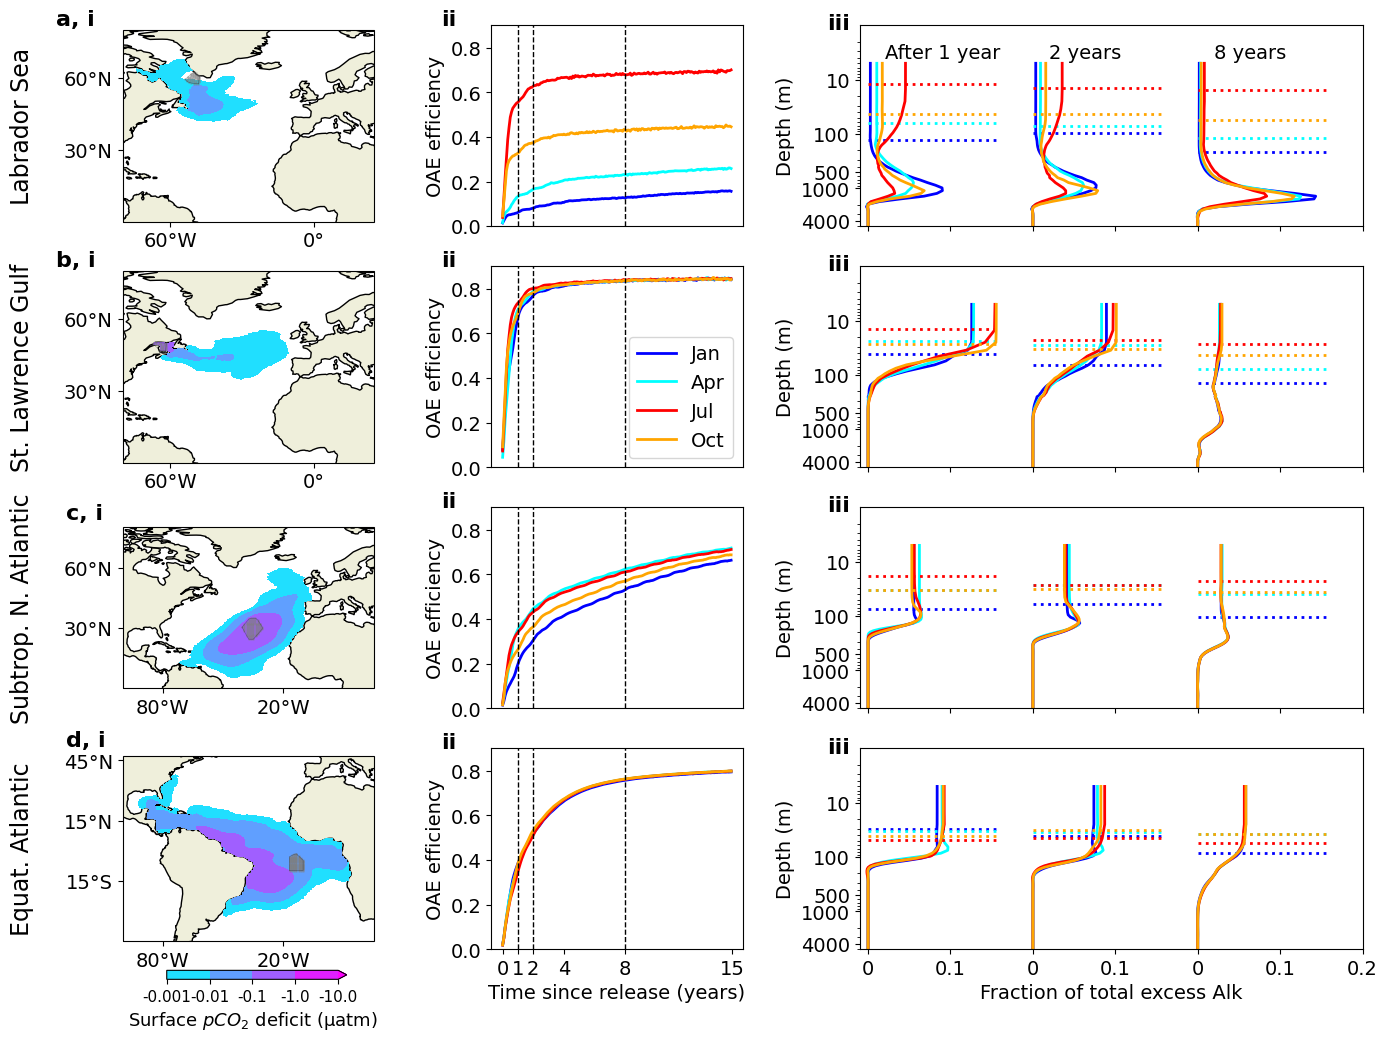

In [102]:
%%time
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(4, 3, width_ratios=[1, 1, 2])

colors = ['blue', 'cyan', 'red', 'orange']
labels = ['Jan', 'Apr', 'Jul', 'Oct']
lon_mins = [-80, -80, -100, -100]
lon_maxs = [25, 25, 25, 25]
lat_mins = [0, 0, 0, -45]
lat_maxs = [80, 80, 80, 47]
central_longitudes = [0, 0, 0, 0]
region_names  = ['Labrador Sea','St. Lawrence Gulf','Subtrop. N. Atlantic','Equat. Atlantic']

def modify_ax_alk(ax):
    ax.set_ylim(5000, 1)
    ax.set_yscale('log')
    
    custom_y_ticks = [10, 100, 500, 1000, 4000]
    custom_y_labels  = [str(num) for num in custom_y_ticks]
    ax.set_yticks(custom_y_ticks)
    ax.set_yticklabels(custom_y_labels);
    
    ax.set_xlim(-0.01, 0.6)
    custom_x_ticks = np.arange(0, 0.7, 0.1)
    custom_x_labels  = [0, 0.1, 0, 0.1, 0, 0.1, 0.2]
    custom_x_labels = [str(num) for num in custom_x_labels]
    ax.set_xticks(custom_x_ticks)
    ax.set_xticklabels(custom_x_labels);


for i in range(4):
    oae_ = oae_effs[i] # OAE_result for a region
    frac_alk_ = fra_alks[i] # frac_alk for a region
    surf_dil = all_curves_global.sel(region=reg, polygon=polys[i])  # surface dilution curves for a polygon, with 4 seasons
    tau_comp = all_curves_global_tau_FG_CO2.sel(region=reg, polygon=polys[i]) # tau gax componets for a region

    
    for j in range(5):
        if j == 0:
            #ax = fig.add_subplot(4, 3, i*3+j+1, projection=ccrs.PlateCarree(central_longitude=central_longitudes[i]))
            ax = plt.subplot(gs[i, j], projection=ccrs.PlateCarree(central_longitude=central_longitudes[i]))
            ax.text(-0.4, 0.5, f'{region_names[i]}', ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize=17)  

            ### add map
            ds_ = util.pop_add_cyclic(dss[i])

            lon_min = lon_mins[i]
            lon_max = lon_maxs[i]
            lat_min = lat_mins[i]
            lat_max = lat_maxs[i]

            custom_colorbar_ticks = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
            negated_numbers = [-num for num in custom_colorbar_ticks]
            custom_colorbar_labels  = [str(num) for num in negated_numbers]

            sca = ax.contourf(ds_.TLONG, ds_.TLAT, -ds_.pCO2_SURF_excess,
                              transform=ccrs.PlateCarree(),
                              cmap=plt.cm.cool,

                              levels = custom_colorbar_ticks,
                              # #levels=[-1e1, -1e0, -1e-1, -1e-2, -1e-3, -1e-4],
                              extend='max',
                              norm=LogNorm(),              
                             );
            def modify(ax):
                ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
                ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
                ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
                lon_formatter = LongitudeFormatter(zero_direction_label=False)
                lat_formatter = LatitudeFormatter()
                ax.xaxis.set_major_formatter(lon_formatter)
                ax.yaxis.set_major_formatter(lat_formatter) 

                ax.add_feature(cfeature.LAND, edgecolor='black')
###### colorbar
                if i == 0:
                    cax = fig.add_axes([-0.27, 0.085, 1, 0.05])  # left, bottom, width, height
                    cb = fig.colorbar(sca, ax=cax, shrink=1, orientation='horizontal')
                    cb.ax.set_title('Surface $pCO_2$ deficit (µatm)', y=-6, fontsize=13)
                    cb.set_ticks(custom_colorbar_ticks)
                    cb.set_ticklabels(custom_colorbar_labels)
                    cb.ax.tick_params(axis='x', labelsize=11)
                
            modify(ax)
            
            ## add polygons
            if i == 0:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 0)
                ax.text(-108, 82, 'a, i', fontsize=16, fontweight='bold')
            elif i == 1:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 63)
                ax.text(-108, 82, 'b, i', fontsize=16, fontweight='bold')
            elif i == 2:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 142)
                ax.text(-128, 84, 'c, i', fontsize=16, fontweight='bold')
            elif i == 3:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 129)
                ax.text(-128, 52, 'd, i', fontsize=16, fontweight='bold')
        
        ################ oae eff
        elif j == 1:
            #ax = fig.add_subplot(4, 3, i*3+j+1)
            ax = plt.subplot(gs[i, j])
            ax.text(-4, 0.9, 'ii', fontsize=16, fontweight='bold')
            
            tarray = np.arange(0, 180, 1)/12
            
            for k in range(4):
                ax.plot(tarray, no_nans(oae_[k].OAE_efficiency.values), linewidth=2, color=colors[k], label=labels[k])
                ax.set_ylim(0, 0.9)
                ax.set_ylabel('OAE efficiency')
            if i == 3:
                ax.set_xlabel('Time since release (years)')
                custom_x_ticks = [0, 1, 2, 4, 8, 15]
                custom_x_labels  = [str(num) for num in custom_x_ticks]
                ax.set_xticks(custom_x_ticks)
                ax.set_xticklabels(custom_x_labels);
            else:
                ax.set_xticks([])

            # add vertical lines
            years_highlight = [1, 2, 8]
            for p in range(len(years_highlight)):
                ax.axvline(years_highlight[p], linestyle='--', color='k',linewidth=1, )
                
            if i == 1:
                ax.legend(loc='lower right')

        ################ vertical profiles of excess alk
        elif j == 2:
            #ax = fig.add_subplot(4, 3, i*3+j+1)
            ax = plt.subplot(gs[i, j])
            ax.text(-0.05, 1.2, 'iii', fontsize=16, fontweight='bold')
            depth_array = frac_alk_invertical.z_t.values/100  # m
            
            mld_ = eff_mld[i] # mld for this polygon
            for k in range(4): # for a season
                ax.plot(frac_alk_[k].frac_alk.isel(time=12*1), depth_array, linewidth=2, color=colors[k], label=labels[k], linestyle='-')
                ax.plot(frac_alk_[k].frac_alk.isel(time=12*2) + 0.2, depth_array, linewidth=2, color=colors[k], linestyle='-')
                ax.plot(frac_alk_[k].frac_alk.isel(time=12*8) + 0.4, depth_array, linewidth=2, color=colors[k], linestyle='-')
                
                # add mld for year 1, 2, 8
                ax.plot([0, 0.2-0.04], [mld_[k,0], mld_[k,0]], color=colors[k], linestyle=':', linewidth=2)
                ax.plot([0.2, 0.4-0.04], [mld_[k,1], mld_[k,1]], color=colors[k], linestyle=':', linewidth=2)
                ax.plot([0.4, 0.6-0.04], [mld_[k,2], mld_[k,2]], color=colors[k], linestyle=':', linewidth=2)
                
                
            modify_ax_alk(ax)
            ax.set_ylabel('Depth (m)')
            if i == 3:
                ax.set_xlabel('Fraction of total excess Alk')
            else:
                ax.set_xticklabels([]);
            if i == 0:
                #ax.legend(loc='upper right')
                ax.text(0.02, 4, f'After 1 year')
                ax.text(0.22, 4, f'2 years')
                ax.text(0.42, 4, f'8 years')
                
                
                
plt.subplots_adjust(wspace=0.35, hspace=0.2)

#plt.savefig('./Figure4_frac_alk_new_weightedMLD_Feb15.png', dpi=400, bbox_inches='tight')

# Fig. 6

In [103]:
from matplotlib import cm

In [105]:
whole_ds = xr.open_dataset('/glade/work/mengyangz/GVP/Manuscript/Uptake_percent/Uptake_percent_maps_all.nc')
whole_ds = xr.open_dataset('./Uptake_percent_maps_all.nc')


mean_over_season = whole_ds.mean(dim='season')
std_over_season = whole_ds.std(dim='season')

mean_over_season = util.pop_add_cyclic(mean_over_season)
std_over_season = util.pop_add_cyclic(std_over_season)

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples

Percentage in 1000, 2000 km [78.64471776] [97.73372664]
['94.90116958979337%', '90.0034956886768%', '70%', '50%', '30%']
Percentage in 1000, 2000 km [91.87046312] [94.13301595]
['94.92559543846097%', '90.00799321827927%', '70%', '50%', '30%']
Percentage in 1000, 2000 km [61.89668045] [78.30839362]
['94.96109699723286%', '90.16812622727387%', '70%', '50%', '30%']
Percentage in 1000, 2000 km [43.9705406] [66.39051773]
['94.90527736306518%', '90.01191242647005%', '70%', '50%', '30%']
CPU times: user 11 s, sys: 302 ms, total: 11.3 s
Wall time: 12.8 s


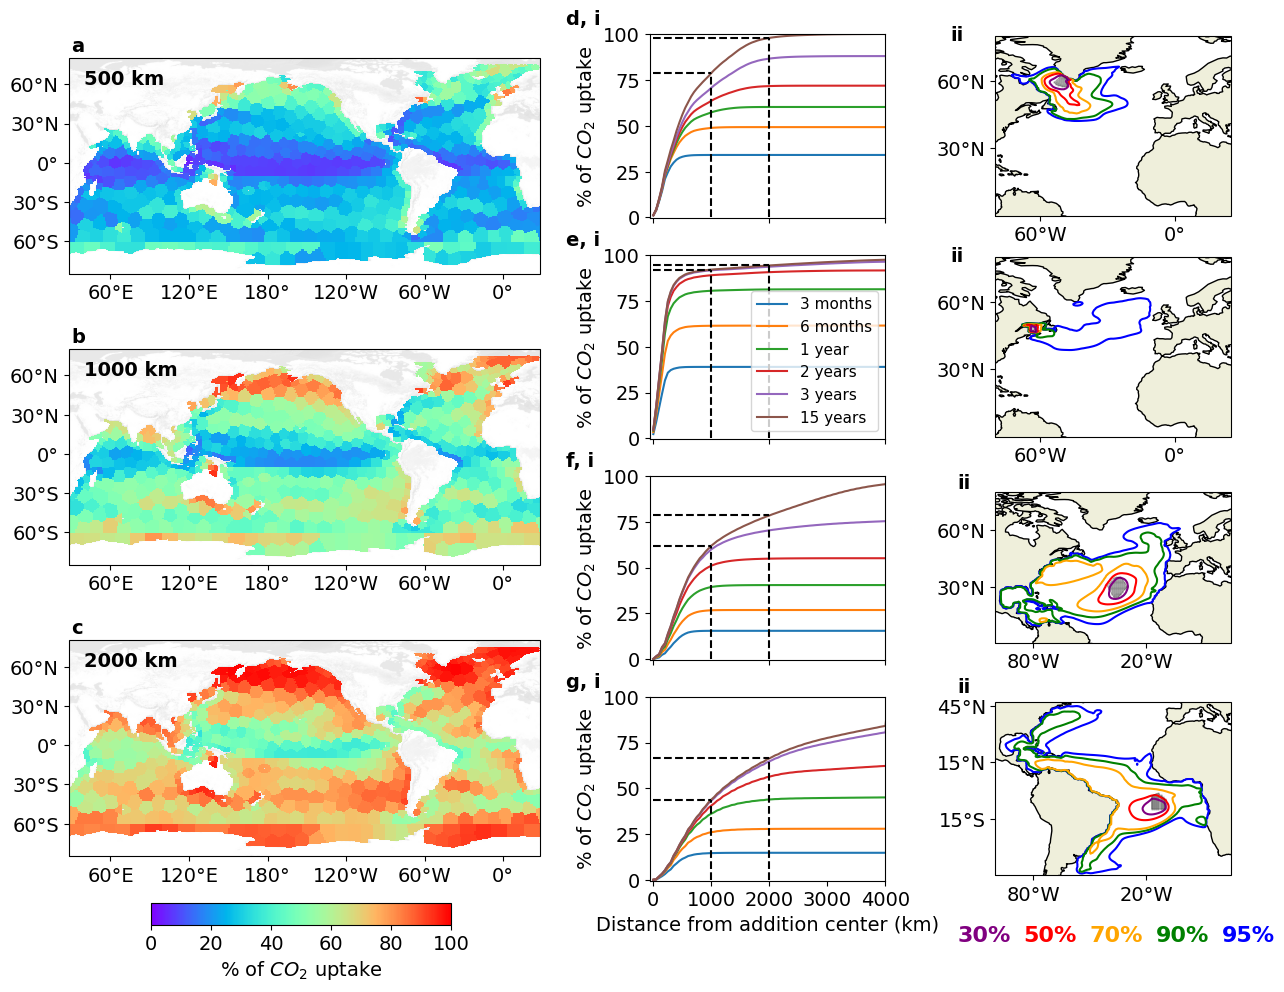

In [106]:
%%time
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(15,11))
gs = gridspec.GridSpec(4, 3, width_ratios=[2, 1, 1])

# Separate the first column into 3 rows
gs_sub1 = gs[:, 0].subgridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.1)

# Now you can access the subgridspec for the first column like this:
ax1 = plt.subplot(gs_sub1[0, 0])
ax2 = plt.subplot(gs_sub1[1, 0])
ax3 = plt.subplot(gs_sub1[2, 0])


################## global maps
time_window = 180
dist2center = 1000

FONTSIZE = 14
def modify(ax):
    ax.set_extent([0, 360, -85, 80], crs=ccrs.PlateCarree())
    #ax.stock_img()
    ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

central_longitude=208

dist2center = [500, 1000, 2000]
labels = ['a  500 km', 'b  1000 km', 'c  2000 km']

for i in range(3):
    ax = plt.subplot(gs_sub1[i, 0],  projection=ccrs.PlateCarree(central_longitude=central_longitude))
    #ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree(central_longitude=central_longitude))
    ax.pcolormesh(mean_over_season.TLONG, mean_over_season.TLAT, mean_over_season.sel(time_window=time_window, dist2center=dist2center[i]).uptake_percent, transform=ccrs.PlateCarree(), cmap='rainbow', vmin=0, vmax=100)
    
    ax.text(40, 60, labels[i][3:], fontsize=FONTSIZE, transform=ccrs.PlateCarree(), fontweight='bold')
    ax.text(30, 85, labels[i][:1], fontsize=FONTSIZE, transform=ccrs.PlateCarree(), fontweight='bold')
    ax.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
    ax.set_yticklabels(ax.get_yticks(), fontsize=FONTSIZE)
    ax.set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree())
    ax.set_xticklabels(ax.get_xticks(), fontsize=FONTSIZE)
        
    modify(ax)
    
def add_colorbar(x0, y0, vmin, vmax, label, num_levels_ticks, cmap_label='rainbow'):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar'
    '''
    cax = fig.add_axes([x0, y0, 0.2, 0.02])  # [x0, y0, width, height]
    cmap = plt.colormaps[cmap_label]
    normalize = plt.Normalize(vmin=vmin, vmax=vmax)  # Normalize the color values
    sm = cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = fig.colorbar(sm, cax=cax, shrink=0.5, label=label, orientation='horizontal', ticks=np.linspace(vmin, vmax, num_levels_ticks))
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.ax.xaxis.label.set_size(FONTSIZE)

add_colorbar(0.18, 0.07, 0, 100, '% of $CO_2$ uptake', 6)


##################################### last 2 columns
colors = ['blue', 'green', 'red', 'orange']
labels = ['Jan', 'Apr', 'Jul', 'Oct']
lon_mins = [-80, -80, -100, -100]
lon_maxs = [25, 25, 25, 25]
lat_mins = [0, 0, 0, -45]
lat_maxs = [80, 80, 80, 47]
central_longitudes = [0, 0, 0, 0]


def modify_ax_alk(ax):
    ax.set_ylim(5000, 1)
    ax.set_yscale('log')
    
    custom_y_ticks = [10, 100, 500, 1000, 4000]
    custom_y_labels  = [str(num) for num in custom_y_ticks]
    ax.set_yticks(custom_y_ticks)
    ax.set_yticklabels(custom_y_labels);
    
    ax.set_xlim(-0.01, 0.6)
    custom_x_ticks = np.arange(0, 0.7, 0.1)
    custom_x_labels  = [0, 0.1, 0, 0.1, 0, 0.1, 0.2]
    custom_x_labels = [str(num) for num in custom_x_labels]
    ax.set_xticks(custom_x_ticks)
    ax.set_xticklabels(custom_x_labels);


for i in range(4):
    oae_ = oae_effs[i] # OAE_result for a region
    frac_alk_ = fra_alks[i] # frac_alk for a region
    surf_dil = all_curves_global.sel(region=reg, polygon=polys[i])  # surface dilution curves for a polygon, with 4 seasons
    tau_comp = all_curves_global_tau_FG_CO2.sel(region=reg, polygon=polys[i]) # tau gax componets for a region

    
    for j in range(3):
       
        if j == 2:
            
            ax = plt.subplot(gs[i, j], projection=ccrs.PlateCarree(central_longitude=central_longitudes[i]))
            
            ### add map
            ds_ = util.pop_add_cyclic(ds_frac_FG_CO2_map[i])

            lon_min = lon_mins[i]
            lon_max = lon_maxs[i]
            lat_min = lat_mins[i]
            lat_max = lat_maxs[i]
            
            custom_colorbar_ticks = L_max_value[i]

            sca = ax.contour(ds_.TLONG, ds_.TLAT, ds_.frac_FG_CO2_cumul,
                              transform=ccrs.PlateCarree(),
                              cmap=plt.cm.RdYlGn,
                              levels = custom_colorbar_ticks,
                              extend='both',
                              #norm=LogNorm(),           
                             );

            # Specify different colors for each level
            contour_colors = ['blue', 'green', 'orange', 'red', 'purple']
            #contour_colors.reverse()
            for o, collection in enumerate(sca.collections):
                collection.set_edgecolor(contour_colors[o])
            
            #### add numbers in contour lines
            # arr = get_sum_inside(ds_, ranges)
            # int_array = list(map(int, arr))

            
            fmt = {}
            strs = [str(ele)+'%' for ele in L_target_sums[i]]
            print(strs)
            for l, s in zip(sca.levels, strs):
                fmt[l] = s
            
            # Label every other level using strings
            ax.clabel(sca, sca.levels, inline=True, fmt=fmt, fontsize=20, inline_spacing=3, colors='k')

                    
            def modify(ax):
                ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
                ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
                ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
                lon_formatter = LongitudeFormatter(zero_direction_label=False)
                lat_formatter = LatitudeFormatter()
                ax.xaxis.set_major_formatter(lon_formatter)
                ax.yaxis.set_major_formatter(lat_formatter) 
                #ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

                ax.add_feature(cfeature.LAND, edgecolor='black')
            modify(ax)
            ## add polygons
            if i == 0:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 0)
                ax.text(-100, 78, 'ii', fontsize=FONTSIZE, fontweight='bold')
            elif i == 1:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 63)
                ax.text(-100, 78, 'ii', fontsize=FONTSIZE, fontweight='bold')
            elif i == 2:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 142)
                ax.text(-120, 82, 'ii', fontsize=FONTSIZE, fontweight='bold')
            elif i == 3:
                plot_polygons(ax, final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, 129)
                ax.text(-120, 52, 'ii', fontsize=FONTSIZE, fontweight='bold')
                percents = [30, 50, 70, 90, 95]
                for kk in range(5):
                    ax.text(-120 + kk*35, -80, f'{percents[kk]}%', fontsize=16, fontweight='bold', color=contour_colors[4-kk])

                
        ################## seasonla mean, CO2 uptake histogram
        elif j == 1:
       
            ax = plt.subplot(gs[i, j])
            
            temp = ds_4poly.isel(polygon=i).mean(dim='season').FG_CO2_percent.values
            if i == 0:
                stacks, _ = get_cumulative_dist(temp, long=True)
            else:
                stacks, _ = get_cumulative_dist(temp)

            legends = ['3 months', '6 months', '1 year', '2 years','3 years', '15 years']
            for jj in range(len(stacks)):
                ax.plot(bin_edges_0/1000, stacks[jj], label=legends[jj])

            ### add dashed line
            ind_1000 = np.where(bin_edges_0/1000 == 1000)
            ax.plot([1000, 1000], [0, stacks[-1][ind_1000]], 'k--')
            ax.plot([0, 1000], [stacks[-1][ind_1000], stacks[-1][ind_1000]], 'k--')

            ind_2000 = np.where(bin_edges_0/1000 == 2000)
            ax.plot([2000, 2000], [0, stacks[-1][ind_2000]], 'k--')
            ax.plot([0, 2000], [stacks[-1][ind_2000], stacks[-1][ind_2000]], 'k--')

            print('Percentage in 1000, 2000 km', stacks[-1][ind_1000], stacks[-1][ind_2000])

            if i == 1:
                ax.legend(fontsize=11, loc='lower right')
            
            ax.set_xlim(-60,4000)
            
            ax.set_xticklabels('')
            ax.set_ylim(-0.2, 100)
            if i == 3:
                ax.set_xlabel('Distance from addition center (km)')
                ax.set_xticks(np.arange(0,5000,1000))
                ax.set_xticklabels(np.arange(0,5000,1000))
            
            ax.set_yticks(np.arange(0,125,25))
            ax.set_yticklabels(np.arange(0,125,25))
        
            if i == 0:
                ax.text(-1500, 105, 'd, i', fontsize=FONTSIZE, fontweight='bold')
            elif i == 1:
                ax.text(-1500, 105, 'e, i', fontsize=FONTSIZE, fontweight='bold')
            elif i == 2:
                ax.text(-1500, 105, 'f, i', fontsize=FONTSIZE, fontweight='bold')
            elif i == 3:
                ax.text(-1500, 105, 'g, i', fontsize=FONTSIZE, fontweight='bold')
            
            ax.set_ylabel('% of $CO_2$ uptake')

            
                
plt.subplots_adjust(wspace=0.35, hspace=0.2)

#plt.savefig('./Figure4_percent_uptake_Feb15.png', dpi=400, bbox_inches='tight')